## Importing libraries

In [ ]:
import sys, os, random
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Dropout, Conv1D, Conv2D, Flatten, Reshape, MaxPooling1D, MaxPooling2D, BatchNormalization, TimeDistributed
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from pathlib import Path
import logging
import keras_tuner as kt

## Getting the data

In [ ]:
data_path = Path("../data/")
# Define data path
X_path = data_path / "ei-cherry_classification_test-image-X_training.npy"
Y_path = data_path / "ei-cherry_classification_test-image-y_training.npy"

# Load the data
X = np.load(X_path.resolve())
Y = np.load(Y_path.resolve())[:,0]

#data_shape
X.shape, Y.shape

In [3]:
X[:,1].max()

np.float32(0.86518824)

	 Label Image==>  1


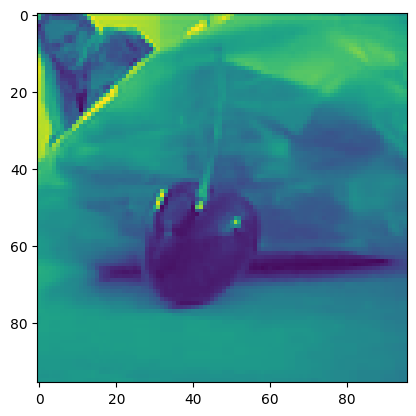

In [4]:
image = X[0]
label = Y[0]

print("\t Label Image==> ",label)
img = tf.reshape(image, (96,96,1)) # 32x32x3 channels
plt.imshow(img);

In [5]:
classes_values = [ "cat", "dog" ]
classes = len(classes_values)

Y = tf.keras.utils.to_categorical(Y - 1, classes)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)
input_length = X_train[0].shape[0]

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
validation_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test))

def get_reshape_function(reshape_to):
    def reshape(image, label):
        return tf.reshape(image, reshape_to), label
    return reshape

callbacks = []

## How to optimize


In [6]:
# define the model 
def model_builder(hp):
    hyper_parm = {
        "conv_blocks": hp.Int(name='conv_blocks',min_value = 2, max_value = 3, default=2),
        "dropout_perc": hp.Choice('dropout_perc', values = [0.1, 0.5, 0.9]),
        "neurons_last": hp.Int('neurons_dense',min_value = 32,max_value = 256, step=32),
        "learning_rate": hp.Choice('learning_rate', values = [5e-4, 1e-5, 5e-5]),
    }
    model = Sequential()
    # tune the number of conv blocks
    for i in range(hyper_parm["conv_blocks"]): # Int specifies the dtype of the values
        # tune the number of filters in the conv_blocks
        #filters = hp.Int('filters_' + str(i),min_value = 32,max_value = 256, step=32)
        filters = hp.Choice('filters_' + str(i),values=[16,32,64,128])
        model.add(Conv2D(filters, kernel_size=3, activation='relu', kernel_constraint=tf.keras.constraints.MaxNorm(1), padding='same'))
        model.add(MaxPooling2D(pool_size=2, strides=2, padding='same'))
    model.add(Flatten())

    model.add(Dropout(hyper_parm["dropout_perc"]))
    # tune the dense layer Choose an optimal value between 32-256
    
    model.add(Dense(hyper_parm["neurons_last"], activation='relu',
    activity_regularizer=tf.keras.regularizers.l1(0.00001)))
    #end of the network
    model.add(Dense(classes, activation='softmax', name='y_pred'))    
    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    opt = Adam(learning_rate=hyper_parm['learning_rate'], beta_1=0.9, beta_2=0.999)

    
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

    return model

In [7]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=20,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt')

Reloading Tuner from my_dir/intro_to_kt/tuner0.json


In [8]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                              patience=5)

In [9]:
# This is only required for some input types, e.g. images
SPECIFIC_INPUT_SHAPE = (96, 96, 1)
train_dataset = train_dataset.map(get_reshape_function(SPECIFIC_INPUT_SHAPE), tf.data.experimental.AUTOTUNE)
validation_dataset = validation_dataset.map(get_reshape_function(SPECIFIC_INPUT_SHAPE), tf.data.experimental.AUTOTUNE)
# this controls the batch size, or you can manipulate the tf.data.Dataset objects yourself
BATCH_SIZE = 32
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=False)
validation_dataset = validation_dataset.batch(BATCH_SIZE, drop_remainder=False)

tuner.search(train_dataset, epochs=10, validation_data=validation_dataset, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]


try:
    print(f"""
    The hyperparameter search is complete. 
    """)
except:
    print("error hyper setting")





    The hyperparameter search is complete. 
    


In [10]:
best_hps

In [11]:
best_hps.values

{'conv_blocks': 3,
 'dropout_perc': 0.5,
 'neurons_dense': 160,
 'learning_rate': 0.0005,
 'filters_0': 128,
 'filters_1': 32,
 'filters_2': 16,
 'filters_3': 32,
 'tuner/epochs': 20,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 0,
 'tuner/round': 0}

In [12]:
# get the best model
best_model = tuner.get_best_models(1)[0]
# display model structure
#plot_model(best_model, 'best_model.png', show_shapes=True)

# show model summary
best_model.summary()

/Users/sac/Documents/GitHub/esp32s3_object_detection/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 128)    │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 32)     │        36,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 16)       │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 160)            │        41,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ y_pred (Dense)                  │ (None, 2)              │           322 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 86,546 (338.07 KB)

 Trainable params: 86,546 (338.07 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
best_hps.values

{'conv_blocks': 3,
 'dropout_perc': 0.5,
 'neurons_dense': 160,
 'learning_rate': 0.0005,
 'filters_0': 128,
 'filters_1': 32,
 'filters_2': 16,
 'filters_3': 32,
 'tuner/epochs': 20,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 0,
 'tuner/round': 0}

In [14]:
# Build the model with the optimal hyperparameters
# train the model.
model2 = tuner.hypermodel.build(best_hps)
history = model2.fit(train_dataset, epochs=50, validation_data=validation_dataset,
           callbacks=[tf.keras.callbacks.EarlyStopping(patience=5)])

Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - accuracy: 0.3379 - loss: 0.7198 - val_accuracy: 0.7895 - val_loss: 0.6077
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.6688 - loss: 0.6460 - val_accuracy: 0.7895 - val_loss: 0.5586
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.6688 - loss: 0.6169 - val_accuracy: 0.7895 - val_loss: 0.5228
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.6688 - loss: 0.5885 - val_accuracy: 0.7895 - val_loss: 0.5065
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.6860 - loss: 0.5595 - val_accuracy: 0.7895 - val_loss: 0.4919
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.7283 - loss: 0.5212 - val_accuracy: 0.8421 - val_loss: 0.4667
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.8180 - loss: 0.4665 - val_accuracy: 0.9474 - val_loss: 0.4014
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9209 - loss: 0.3758 - val_accuracy: 0.9474 - val_loss: 0.3248

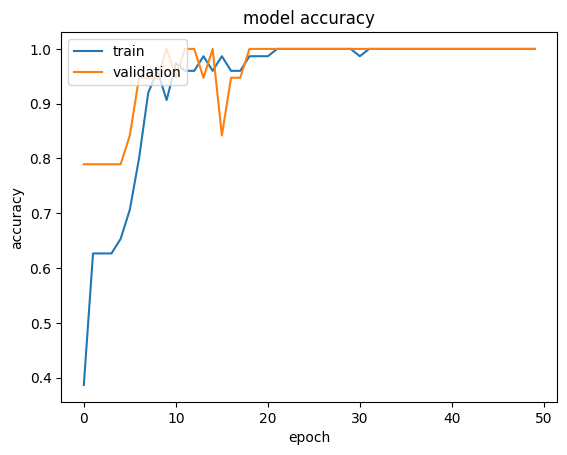

In [15]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [16]:
model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 96, 96, 128)    │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 48, 48, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 48, 48, 32)     │        36,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 24, 24, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 12, 12, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 160)            │       368,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ y_pred (Dense)                  │ (None, 2)              │           322 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,235,768 (4.71 MB)

 Trainable params: 411,922 (1.57 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 823,846 (3.14 MB)

In [17]:
#model2 = tf.keras.models.load_model('saved_model.keras') 
#model2.summary()

In [18]:
# Save the model to disk
best_model.export('saved_model.zip')

INFO:tensorflow:Assets written to: saved_model.zip/assets


INFO:tensorflow:Assets written to: saved_model.zip/assets


Saved artifact at 'saved_model.zip'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  6076388688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6076384464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6076383312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6076398096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6076398288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6076397712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6078302736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6078303696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6076390608: TensorSpec(shape=(), dtype=tf.float32, name=None)
  6078304080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6078305040: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [19]:
import edgeimpulse as ei

# Change to an API key from your Edge Impulse project
API_KEY = "ei_47faec1d19956cff1c6fcf700ae28fd238f65385b9160831cf8d5fade12f8d67"
ei.API_KEY = API_KEY


In [20]:
ei.model.list_profile_devices()

['alif-he',
 'alif-hp',
 'ambiq-apollo4',
 'arduino-nano-33-ble',
 'arduino-nicla-vision',
 'arduino-nicla-vision-m4',
 'portenta-h7',
 'brainchip-akd1000',
 'brickml',
 'cortex-m4f-80mhz',
 'cortex-m7-216mhz',
 'nxp-imx93-npu',
 'nxp-imx93-cpu',
 'espressif-esp32',
 'himax-we-i',
 'himax-wiseeye2',
 'himax-wiseeye2-ethos',
 'infineon-cy8ckit-062s2',
 'infineon-cy8ckit-062-ble',
 'mbp-16-2020',
 'memryx-mx3',
 'microchip-sama7g54',
 'nordic-nrf52840-dk',
 'nordic-nrf5340-dk',
 'nordic-nrf9151-dk',
 'nordic-nrf9160-dk',
 'nordic-nrf9161-dk',
 'jetson-nano',
 'jetson-orin-nx',
 'jetson-orin-nano',
 'openmv-h7p',
 'particle-boron',
 'particle-p2',
 'raspberry-pi-4',
 'raspberry-pi-5',
 'raspberry-pi-rp2040',
 'renesas-ck-ra6m5',
 'renesas-ek-ra8d1',
 'renesas-rzg2l',
 'renesas-rzv2l-cpu',
 'renesas-rzv2l',
 'st-iot-discovery-kit',
 'seeed-sense-cap',
 'wio-terminal',
 'seeed-vision-ai',
 'silabs-xg24',
 'silabs-thunderboard-sense-2',
 'sony-spresense',
 'synaptics-ka10000',
 'ti-am62a',
 

In [21]:
ei.model.list_engines()

['tflite',
 'tflite-eon',
 'tflite-eon-ram-optimized',
 'tensorrt',
 'tensaiflow',
 'drp-ai',
 'tidl',
 'akida',
 'syntiant',
 'memryx',
 'neox',
 'ethos-linux']

In [22]:
try:
    profile = ei.model.profile(model = best_model, 
                               device="espressif-esp32",
                              )
    print(profile.summary())
except:
    print(f"could not profile: ")

INFO:tensorflow:Assets written to: /var/folders/4q/t2hdwl4d1x340j9364kz54s0kz8_1q/T/tmpachwx0dh/saved_model/assets


INFO:tensorflow:Assets written to: /var/folders/4q/t2hdwl4d1x340j9364kz54s0kz8_1q/T/tmpachwx0dh/saved_model/assets


Saved artifact at '/var/folders/4q/t2hdwl4d1x340j9364kz54s0kz8_1q/T/tmpachwx0dh/saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  6076388688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6076384464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6076383312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6076398096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6076398288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6076397712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6078302736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6078303696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6076390608: TensorSpec(shape=(), dtype=tf.float32, name=None)
  6078304080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6078305040:

In [ ]:
ei.model.list_deployment_targets()

In [ ]:
labels = [ "cat", "dog"]
num_classes = len(labels)
deploy_filename = "my_model_cpp.zip"

In [ ]:
# Set model information, such as your list of labels
model_output_type = ei.model.output_type.Classification(labels=labels)

# Set model input type
#model_input_type = ei.model.input_type.OtherInput()

# Create C++ library with trained model
deploy_bytes = None
try:
    
    deploy_bytes = ei.model.deploy(model=best_model,
                                   model_output_type=model_output_type,
                                   model_input_type=model_input_type,
                                   deploy_target='arduino',
                                   engine='tflite')
except Exception as e:
    print(f"Could not deploy: {e}")
    
# Write the downloaded raw bytes to a file
if deploy_bytes:
    with open(deploy_filename, 'wb') as f:
        f.write(deploy_bytes.getvalue())